<a href="https://colab.research.google.com/github/aymenchibouti/newversion/blob/master/table_data_res.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd

# تحميل البيانات
df = pd.read_csv("model1_210_features.csv")

# استخراج بيانات النشاط فقط (كل الأعمدة التي تبدأ بـ 'day_')
activity_cols = [col for col in df.columns if col.startswith("day_")]
activity_data = df[activity_cols].copy()

# إضافة معرف المستخدم
activity_data["user_id"] = df["enrollment_id"]

# تحويل البيانات إلى الشكل الطولي (زمني)
melted = pd.melt(
    activity_data,
    id_vars=["user_id"],
    var_name="day_activity",
    value_name="value"
)

# استخراج اليوم ونوع النشاط من اسم العمود
melted[["day", "activity"]] = melted["day_activity"].str.extract(r"day_(\d+)_(.+)")
melted["day"] = melted["day"].astype(int)

# اختيار الأعمدة النهائية
time_series_df = melted[["user_id", "day", "activity", "value"]]

# (اختياري) إضافة عمود dropout لكل user
dropout_map = df.set_index("enrollment_id")["dropout"]
time_series_df["dropout"] = time_series_df["user_id"].map(dropout_map)

# حفظ النتائج في ملف CSV جديد (اختياري)
time_series_df.to_csv("reshaped_time_series.csv", index=False)

# عرض أول 10 صفوف
print(time_series_df.head(10))


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [7]:
import pandas as pd

In [8]:
ts = pd.read_csv("reshaped_time_series.csv")

In [9]:
ts

,user_id,day,activity,value,dropout
0,1,1,access,3,0
1,3,1,access,7,0
2,4,1,access,18,0
3,5,1,access,0,0
4,6,1,access,12,0
...,...,...,...,...,...
25313815,200898,30,video,0,1
25313816,200900,30,video,0,1
25313817,200901,30,video,0,1
25313818,200904,30,video,0,1


In [10]:
import pandas as pd

# Step 1: Load data
df = pd.read_csv("model1_210_features.csv")

# Step 2: Extract activity columns and user ID
activity_cols = [col for col in df.columns if col.startswith("day_")]
activity_data = df[activity_cols].copy()
activity_data["user_id"] = df["enrollment_id"]

# Step 3: Melt to long format
melted = pd.melt(activity_data, id_vars=["user_id"], var_name="day_activity", value_name="value")

# Step 4: Extract day and activity type
melted[["day", "activity"]] = melted["day_activity"].str.extract(r"day_(\d+)_(.+)")
melted["day"] = melted["day"].astype(int)

# Step 5: Pivot table: one row per user per day, columns = activity types
pivoted = melted.pivot_table(index=["user_id", "day"], columns="activity", values="value", fill_value=0).reset_index()

# Step 6: Aggregate by user: extract mean, sum, std, min, max per activity
aggregated = pivoted.groupby("user_id").agg(['mean', 'sum', 'std', 'min', 'max'])

# Step 7: Flatten columns
aggregated.columns = ['_'.join(col) for col in aggregated.columns]
aggregated = aggregated.reset_index()

# Step 8: Add dropout label
aggregated = aggregated.merge(df[["enrollment_id", "dropout"]], left_on="user_id", right_on="enrollment_id", how="left")
aggregated.drop(columns=["enrollment_id"], inplace=True)

# Step 9: Save to CSV (optional)
aggregated.to_csv("aggregated_features_for_dropout_prediction.csv", index=False)

# Step 10: Ready for ML!
print(aggregated.head())


   user_id  day_mean  day_sum   day_std  day_min  day_max  access_mean  \
0        1      15.5      465  8.803408        1       30     3.566667   
1        3      15.5      465  8.803408        1       30     2.633333   
2        4      15.5      465  8.803408        1       30     2.133333   
3        5      15.5      465  8.803408        1       30     7.533333   
4        6      15.5      465  8.803408        1       30     0.400000   

   access_sum  access_std  access_min  ...  video_sum  video_std  video_min  \
0       107.0    6.382537         0.0  ...       29.0   3.167544        0.0   
1        79.0    5.235709         0.0  ...        9.0   1.022168        0.0   
2        64.0    4.400104         0.0  ...        4.0   0.434172        0.0   
3       226.0   13.320281         0.0  ...       86.0   5.661323        0.0   
4        12.0    2.190890         0.0  ...        2.0   0.365148        0.0   

   video_max  wiki_mean  wiki_sum  wiki_std  wiki_min  wiki_max  dropout  
0    

In [12]:
ag = pd.read_csv("aggregated_features_for_dropout_prediction.csv")

In [13]:
ag

,user_id,day_mean,day_sum,day_std,day_min,day_max,access_mean,access_sum,access_std,access_min,...,video_sum,video_std,video_min,video_max,wiki_mean,wiki_sum,wiki_std,wiki_min,wiki_max,dropout
0,1,15.5,465,8.803408,1,30,3.566667,107.0,6.382537,0.0,...,29.0,3.167544,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0
1,3,15.5,465,8.803408,1,30,2.633333,79.0,5.235709,0.0,...,9.0,1.022168,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0
2,4,15.5,465,8.803408,1,30,2.133333,64.0,4.400104,0.0,...,4.0,0.434172,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0
3,5,15.5,465,8.803408,1,30,7.533333,226.0,13.320281,0.0,...,86.0,5.661323,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0
4,6,15.5,465,8.803408,1,30,0.400000,12.0,2.190890,0.0,...,2.0,0.365148,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120537,200898,15.5,465,8.803408,1,30,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
120538,200900,15.5,465,8.803408,1,30,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
120539,200901,15.5,465,8.803408,1,30,0.100000,3.0,0.547723,0.0,...,1.0,0.182574,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
120540,200904,15.5,465,8.803408,1,30,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = aggregated.drop(columns=["user_id", "dropout"])
y = aggregated["dropout"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.73      0.53      0.62      5061
           1       0.88      0.95      0.91     19048

    accuracy                           0.86     24109
   macro avg       0.81      0.74      0.76     24109
weighted avg       0.85      0.86      0.85     24109



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:07:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.53      0.62      5061
           1       0.88      0.95      0.92     19048

    accuracy                           0.86     24109
   macro avg       0.82      0.74      0.77     24109
weighted avg       0.86      0.86      0.86     24109



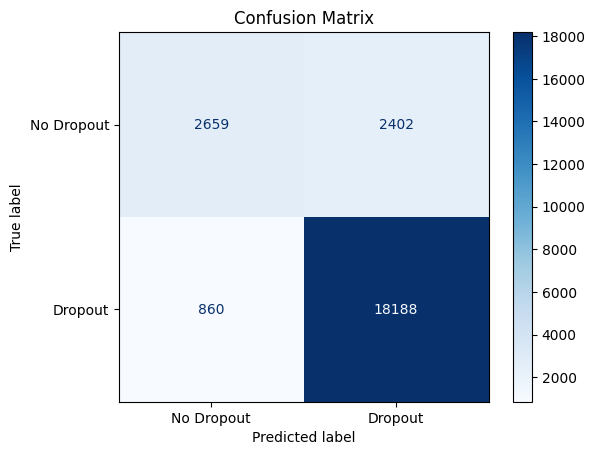

/tmp/ipython-input-2243808958.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_imp_df, palette="viridis")


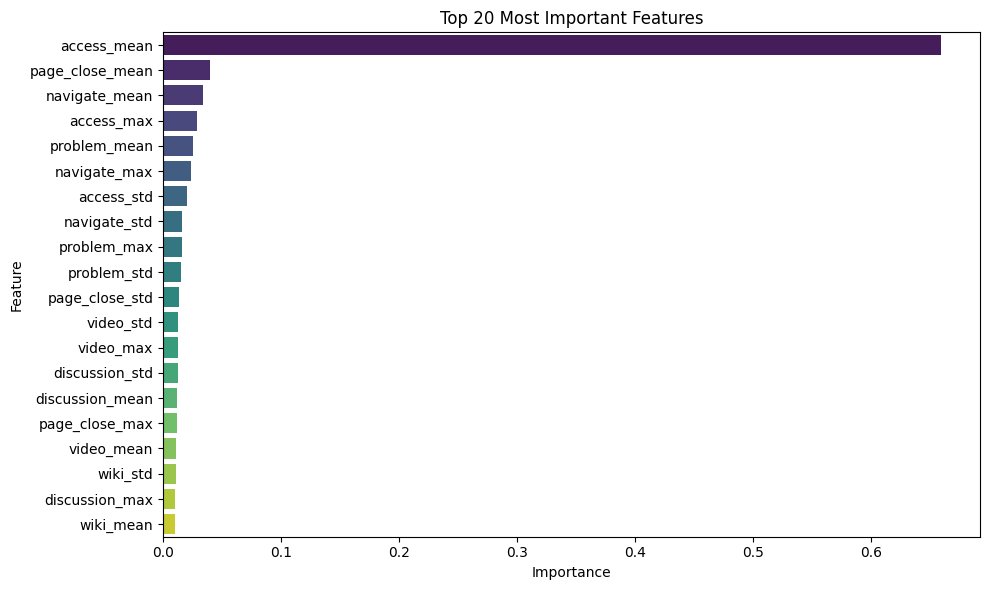

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. تحميل البيانات
df = pd.read_csv("aggregated_features_for_dropout_prediction.csv")

# 2. فصل الميزات والهدف
X = df.drop(columns=["user_id", "dropout"])
y = df["dropout"]

# 3. توحيد البيانات
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 5. إنشاء وتدريب النموذج
model = XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# 6. التنبؤ
y_pred = model.predict(X_test)

# 7. عرض تقرير التصنيف
print("Classification Report:\n", classification_report(y_test, y_pred))

# 8. رسم مصفوفة الالتباس
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Dropout", "Dropout"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# 9. استخراج أهم الميزات
importances = model.feature_importances_
feature_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by="Importance", ascending=False).head(20)

# 10. رسم أهم 20 ميزة
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feat_imp_df, palette="viridis")
plt.title("Top 20 Most Important Features")
plt.tight_layout()
plt.show()


In [17]:
!pip install pandas matplotlib seaborn scikit-learn xgboost catboost imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.5 MB/s eta 0:00:00


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:19:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:21:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Accuracy: 0.8535401717201045

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.63      0.64      5061
           1       0.90      0.91      0.91     19048

    accuracy                           0.85     24109
   macro avg       0.78      0.77      0.78     24109
weighted avg       0.85      0.85      0.85     24109



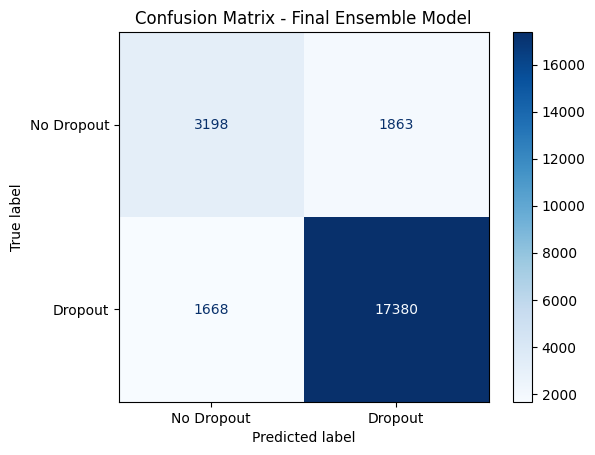

/tmp/ipython-input-1804793111.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=xgb_feat_df, x="Importance", y="Feature", palette="viridis")


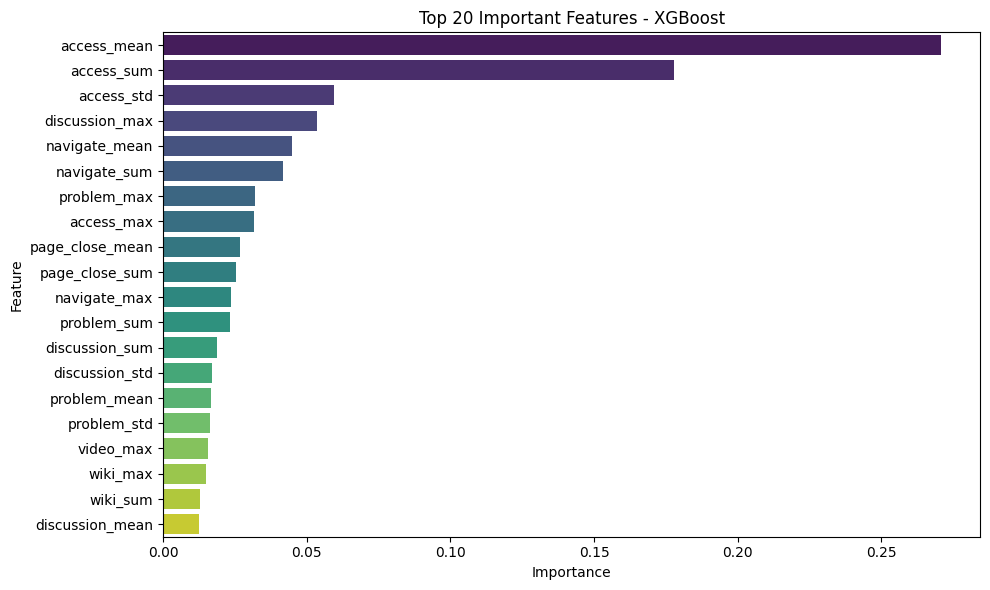

/tmp/ipython-input-1804793111.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cat_feat_df, x="Importance", y="Feature", palette="rocket")


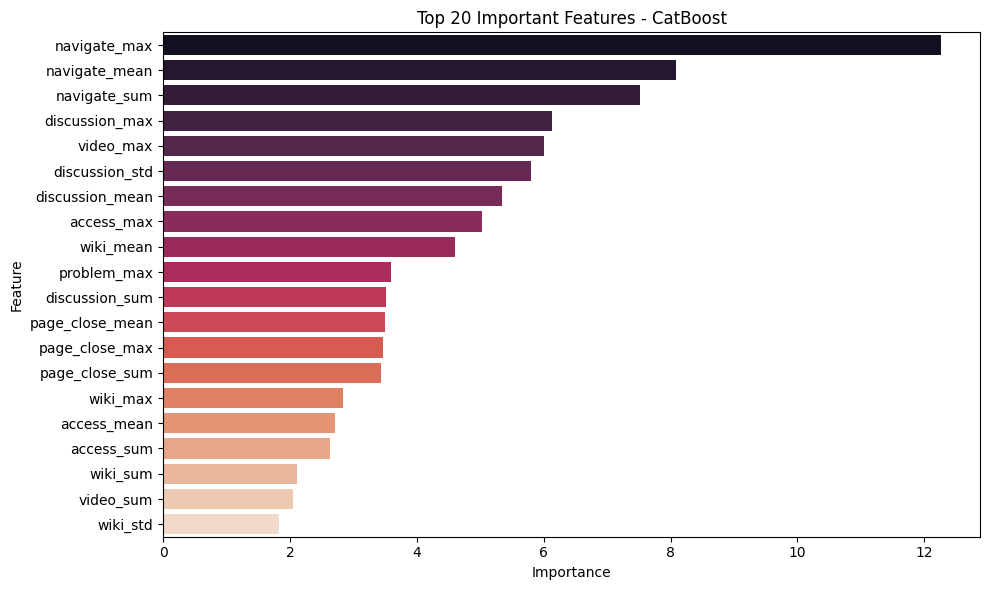

In [18]:
# ============================
# 1. المكتبات
# ============================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

# ============================
# 2. تحميل البيانات
# ============================
df = pd.read_csv("aggregated_features_for_dropout_prediction.csv")
X = df.drop(columns=["user_id", "dropout"])
y = df["dropout"]

# ============================
# 3. معالجة البيانات
# ============================
# توحيد الميزات
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# تقسيم إلى تدريب واختبار
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# معالجة عدم توازن الفئات
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# ============================
# 4. ضبط نموذج XGBoost
# ============================
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
xgb_random.fit(X_resampled, y_resampled)
best_xgb = xgb_random.best_estimator_

# ============================
# 5. تدريب باقي النماذج
# ============================
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
cat = CatBoostClassifier(verbose=0, iterations=300, learning_rate=0.05, depth=6)

rf.fit(X_resampled, y_resampled)
cat.fit(X_resampled, y_resampled)

# ============================
# 6. نموذج Ensemble Voting
# ============================
voting = VotingClassifier(estimators=[
    ('xgb', best_xgb),
    ('rf', rf),
    ('cat', cat)
], voting='soft')

voting.fit(X_resampled, y_resampled)
y_pred = voting.predict(X_test)

# ============================
# 7. التقييم
# ============================
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

# ===== مصفوفة الالتباس =====
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Dropout", "Dropout"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Final Ensemble Model")
plt.show()

# ============================
# 8. أهم الميزات من XGBoost
# ============================
xgb_importances = best_xgb.feature_importances_
xgb_feat_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb_importances
}).sort_values(by="Importance", ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=xgb_feat_df, x="Importance", y="Feature", palette="viridis")
plt.title("Top 20 Important Features - XGBoost")
plt.tight_layout()
plt.show()

# ============================
# 9. أهم الميزات من CatBoost
# ============================
cat_importances = cat.get_feature_importance()
cat_feat_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": cat_importances
}).sort_values(by="Importance", ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=cat_feat_df, x="Importance", y="Feature", palette="rocket")
plt.title("Top 20 Important Features - CatBoost")
plt.tight_layout()
plt.show()
